# AI - CA3 - 810196462

In [1]:
from __future__ import unicode_literals
import pandas as pd
from hazm import *
from typing import Dict

In [2]:
train_data = pd.read_csv('Data/divar_train.csv')
categories = train_data.categories.unique()
categories

array(['leisure-hobbies', 'vehicles', 'for-the-home', 'personal',
       'electronic-devices', 'businesses'], dtype=object)

In [20]:
category_words = {}
category_words_count = {}
for category in categories:
    category_words[category] = {}
    category_words_count[category] = 0

stop_words = [
    'و', 'یا', 'در', '\n', '\r',
    '-',
    '؛',
    ':',
    '.',
    '،',
    '؟',
    '!',
    ')',
    '(',
    'برای',
    'است',
    'هست',
    'به',
    'با',
    'که',
    'را',
    'بود',
    'علت',
    '...'
]

def extract_words(sentence):
    return [w for w in word_tokenize(sentence) if w not in stop_words]
    
    
def add_to_category_dict(category, words):
    for word in words:
        if word in category_words[category]:
            category_words[category][word] += 1
        else:
            category_words[category][word] = 1
    category_words_count[category] += 1
        
    
for index, row in train_data.iterrows():
    row_category = row['categories']
    title_words = extract_words(row['title'])
    desc_words = extract_words(row['description'])
    add_to_category_dict(row_category, set(title_words + desc_words))

In [4]:
category_words_count

{'leisure-hobbies': 1700,
 'vehicles': 1700,
 'for-the-home': 1700,
 'personal': 1700,
 'electronic-devices': 1700,
 'businesses': 1700}

## Problem Solving (Unigram)
### naive bayes
$$ P(c|X) = P(x_1|c) * P(x_2|c) * ... * P(x_n|c) * P(c)  $$

In [5]:
def make_dict_with_cats():
    cat_dict = {}
    for cat in categories:
        cat_dict[cat] = 0
    return cat_dict

In [6]:
from dataclasses import dataclass


@dataclass
class PredicateData:
    total: int
    correct_detected: int
    all_detected_class: Dict[str, int]
    total_class: Dict[str, int]
    correct_detected_class: Dict[str, int]

In [7]:
import random

test_data = pd.read_csv('Data/divar_test.csv')


def predict_category(smoothing = False):
    predicate_data = PredicateData(
        0,
        0,
        make_dict_with_cats(),
        make_dict_with_cats(),
        make_dict_with_cats()
    )


    for index, row in test_data.iterrows():
        all_text_words = extract_words(row['title']) + extract_words(row['description'])
        max_cat = '' if smoothing == True else categories[random.randint(0, 5)]
        max_prob = 0

        P_c_X = {}
        for category in categories:
            P_c_X[category] = 1
            for word in all_text_words:
                P_xi_c = 0
                if word not in category_words[category]:
                    category_words[category][word] = 0
                if smoothing:
                    P_xi_c = (category_words[category][word] + 1) / \
                        (category_words_count[category] + len(category_words[category]) + 1)
                else:
                    P_xi_c = category_words[category][word]/category_words_count[category]
                P_c_X[category] *= P_xi_c

            P_c_X[category] *= 1/6
            if P_c_X[category] > max_prob:
                max_prob = P_c_X[category]
                max_cat = category
        if max_prob == 0:
            max_cat = categories[random.randint(0,5)]
        predicate_data.total += 1
        predicate_data.all_detected_class[max_cat] += 1
        predicate_data.total_class[row['categories']] += 1
        if max_cat == row['categories']:
            predicate_data.correct_detected += 1
            predicate_data.correct_detected_class[max_cat] += 1
    return predicate_data

## Bar chart of train categories

[('سالم', 337), ('یک', 266), ('قیمت', 248), ('فروش', 242), ('از', 241), ('جفت', 238)]


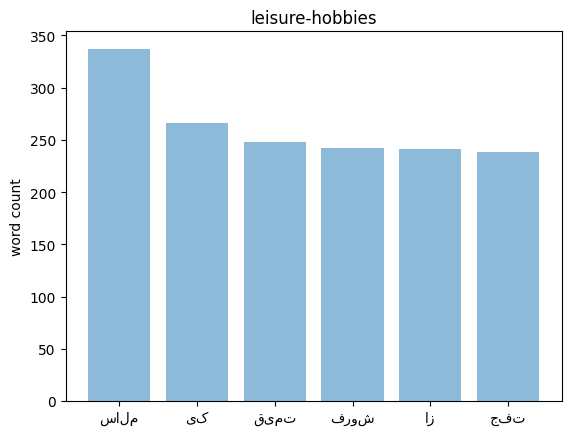

[('بیمه', 634), ('رنگ', 603), ('سالم', 600), ('مدل', 496), ('بدون', 444), ('تخفیف', 374)]


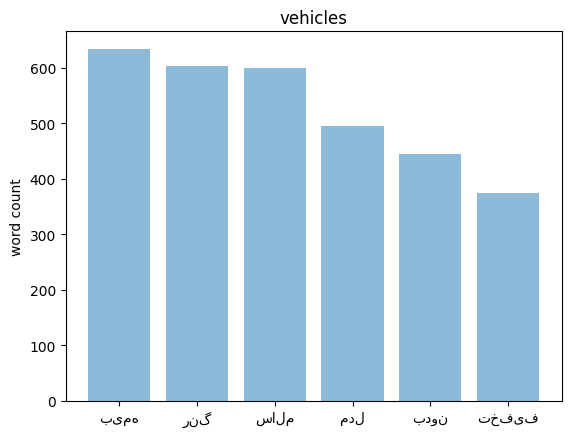

[('سالم', 442), ('نو', 427), ('میز', 302), ('تمیز', 263), ('کاملا', 211), ('نفره', 210)]


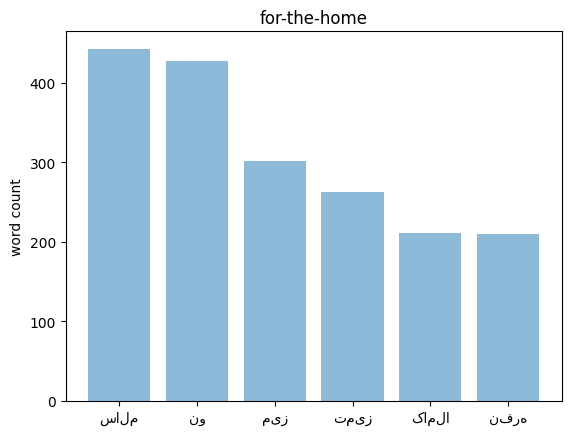

[('نو', 613), ('سایز', 597), ('فقط', 265), ('استفاده', 260), ('قیمت', 248), ('لباس', 237)]


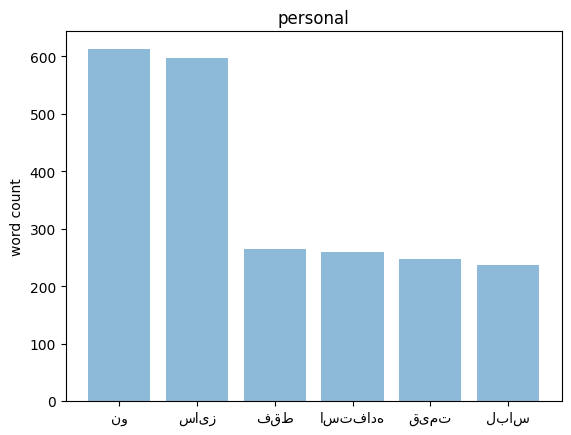

[('سالم', 527), ('گوشی', 448), ('تمیز', 302), ('بدون', 292), ('فقط', 259), ('نو', 253)]


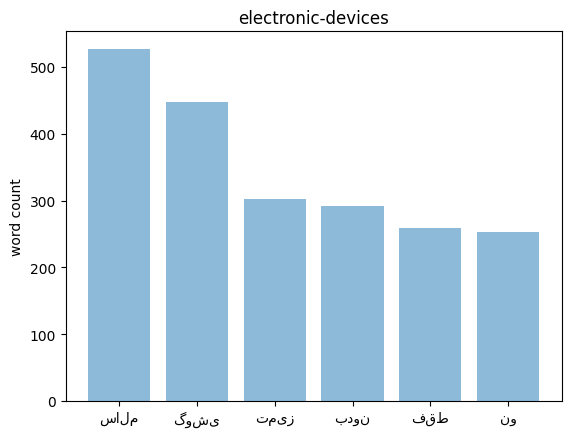

[('فروش', 424), ('نو', 307), ('سالم', 301), ('عدد', 294), ('قیمت', 288), ('دستگاه', 251)]


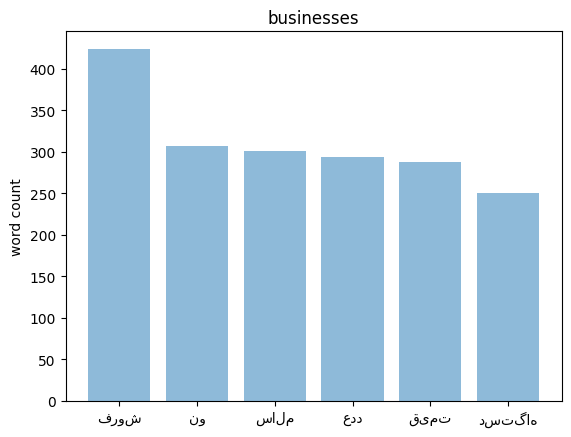

In [16]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

for cat in categories:
    top_5_word_frequency = sorted(list(category_words[cat].items()), key=lambda item: item[1], reverse=True)[:6]
    print(top_5_word_frequency)
    words = [w[0] for w in top_5_word_frequency]
    frequencies = [f[1] for f in top_5_word_frequency]

    plt.figure()
    plt.bar(words, frequencies, align='center', alpha=0.5)
    # plt.xticks(y_pos, list(objects.keys()))
    plt.ylabel('word count')
    plt.title(cat)

    plt.show()

In [9]:
def scale_len(num, expected_precesion):
    num_str = str(num)
    diff = abs(len(num_str.split('.')[1]) - expected_precesion)
    num_str += ('0' * diff)
    return num_str

# print(scale_len(12.5, 10))

In [17]:
def evaluation(predicate_data):
    f1_score_sum = 0
    f1_score_weighted_sum = 0
    print("Category \t Precision \t Recall \t F1 Score")
    for cat in categories:
        print(cat, end='\t')
        precision = predicate_data.correct_detected_class[cat] / predicate_data.all_detected_class[cat]
        recall = predicate_data.correct_detected_class[cat] / predicate_data.total_class[cat]
        f1_score = 2 * precision * recall / (precision + recall)
        f1_score_sum += f1_score
        f1_score_weighted_sum += predicate_data.total_class[cat] * f1_score
        print(precision, '\t', recall, '\t', f1_score)


    macro_avg_f1 = f1_score_sum / len(categories)
    micro_avg_f1 = predicate_data.correct_detected / predicate_data.total
    weighted_avg_f1 = f1_score_weighted_sum / predicate_data.total
    accuracy = predicate_data.correct_detected / predicate_data.total
    print("================================================================")
    print("Result of the Naive Bayes without without additive smoothing")
    print('accuracy:', accuracy)
    print('macro_avg_f1:', macro_avg_f1)
    print('micro_avg_f1:', micro_avg_f1)
    print('weighted_avg_f1:', weighted_avg_f1)


In [18]:
predict_data = predict_category()
predict_data

PredicateData(total=1800, correct_detected=691, all_detected_class={'leisure-hobbies': 261, 'vehicles': 287, 'for-the-home': 311, 'personal': 348, 'electronic-devices': 288, 'businesses': 305}, total_class={'leisure-hobbies': 300, 'vehicles': 300, 'for-the-home': 300, 'personal': 300, 'electronic-devices': 300, 'businesses': 300}, correct_detected_class={'leisure-hobbies': 97, 'vehicles': 118, 'for-the-home': 124, 'personal': 142, 'electronic-devices': 95, 'businesses': 115})

In [19]:
evaluation(predict_data)

Category 	 Precision 	 Recall 	 F1 Score
leisure-hobbies	0.3716475095785441 	 0.3233333333333333 	 0.34581105169340465
vehicles	0.41114982578397213 	 0.3933333333333333 	 0.40204429301533223
for-the-home	0.3987138263665595 	 0.41333333333333333 	 0.4058919803600655
personal	0.40804597701149425 	 0.47333333333333333 	 0.43827160493827166
electronic-devices	0.3298611111111111 	 0.31666666666666665 	 0.32312925170068024
businesses	0.3770491803278688 	 0.38333333333333336 	 0.38016528925619836
Result of the Naive Bayes without without additive smoothing
accuracy: 0.3838888888888889
macro_avg_f1: 0.3825522451606587
micro_avg_f1: 0.3838888888888889
weighted_avg_f1: 0.3825522451606588


## Additive Smoothing


In [13]:
predict_data = predict_category(True)
predict_data

PredicateData(total=1800, correct_detected=1550, all_detected_class={'leisure-hobbies': 270, 'vehicles': 304, 'for-the-home': 308, 'personal': 315, 'electronic-devices': 320, 'businesses': 283}, total_class={'leisure-hobbies': 300, 'vehicles': 300, 'for-the-home': 300, 'personal': 300, 'electronic-devices': 300, 'businesses': 300}, correct_detected_class={'leisure-hobbies': 247, 'vehicles': 271, 'for-the-home': 255, 'personal': 269, 'electronic-devices': 281, 'businesses': 227})

In [14]:
evaluation(predict_data)

Category 	 Precision 	 Recall 	 F1 Score
leisure-hobbies	0.9148148148148149 	 0.8233333333333334 	 0.8666666666666667
vehicles	0.8914473684210527 	 0.9033333333333333 	 0.8973509933774835
for-the-home	0.827922077922078 	 0.85 	 0.8388157894736843
personal	0.8539682539682539 	 0.8966666666666666 	 0.8747967479674796
electronic-devices	0.878125 	 0.9366666666666666 	 0.9064516129032257
businesses	0.8021201413427562 	 0.7566666666666667 	 0.7787307032590051
Result of the Naive Bayes without without additive smoothing
accuracy: 0.8611111111111112
macro_avg_f1: 0.8604687522745907
micro_avg_f1: 0.8611111111111112
weighted_avg_f1: 0.860468752274591
